# Classification of text documents

In [2]:
import nltk
import pandas as pd
%pylab inline
from nltk.corpus import stopwords
import gensim
from gensim import corpora, models, similarities
import re
import random
import time
import pickle

import sklearn
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

Populating the interactive namespace from numpy and matplotlib


### Import OAG data

In [3]:
# load OAG online data
oag_data = pd.read_csv("../data/OAG Complaints-Online_Final.csv")
oag_doc = list(oag_data['COMPLAINT_DESCRIPTION'])
print len(oag_doc)

15034


In [4]:
# remove duplicate
oag_doc = list(set(oag_doc))
print oag_doc[:2]

[nan, 'Note User indicated supporting documents will be mailed within - days They rent cars for Uber to TLC drivers in NYC  There cars are problematic and inoperableYou can see the google reviews or BBB complaints against themThey have our ---- usd deposit and one week of rent --- plus loss of wages for two drivers ie ---- usd']


In [5]:
# remove nan
oag_doc = oag_doc[1:]
print len(oag_doc)

11635


### Import Tweets

In [249]:
# load tweets
twitterdata = pd.read_csv("../data/fraud_list_svarmit_location_v1.csv", header=None)
print len(twitterdata)

7401520


In [254]:
twitterdata.head()

,tweet,date,unknow1,unknow2,unknow3,unknow4,unknow5,place,geolocation,unknow6
0,"I hate when ppl be like, if u an Mercedes ain'...",Fri Apr 29 00:35:25 +0000 2016,False,0.0,725845912573087745,3.306932e+09,312,"Brooklyn, NY","[[-74.041878, 40.570842], [-74.041878, 40.7394...",[]
1,RT @Adel__Almalki: #tech #news ( #EggTV )U.S. ...,Fri Apr 29 00:35:25 +0000 2016,False,0.0,725845913244033027,7.220385e+17,10,NaN,NaN,"[{u'indices': [19, 24], u'text': u'tech'}, {u'..."
2,RT @ColonelRTeenda: Jui mort Nehuda elle a lai...,Fri Apr 29 00:35:25 +0000 2016,False,0.0,725845912661151744,3.113654e+09,725,NaN,NaN,"[{u'indices': [115, 125], u'text': u'LesAnges8'}]"
3,RT @IrishMason: Pretty please Rachel? Now tha...,Fri Apr 29 00:35:25 +0000 2016,False,0.0,725845912996728832,4.806702e+08,204,NaN,NaN,[]
4,Overwatch beta begins when summer classes star...,Fri Apr 29 00:35:25 +0000 2016,False,0.0,725845913378377728,1.449872e+09,222,"Manhattan, NY","[[-74.026675, 40.683935], [-74.026675, 40.8774...",[]


In [199]:
tweet_doc = list(twitterdata.iloc[:,0])

In [7]:
# random select 30000 tweets
selected_tweet_index = list(randint(0, len(tweet_doc),100000))

# filter meaningless tweets
selected_tweet = [tweet_doc[i] for i in selected_tweet_index if type(tweet_doc[i]) == str and len(tweet_doc[i].split()) > 20]

print len(selected_tweet)

19890


In [8]:
# Get random 1000000 unselected tweet
unselected_tweet_index =[]
count = 0
for i in randint(0, len(tweet_doc), 3000000):
    if i not in selected_tweet_index:
        unselected_tweet_index.append(i)
        count += 1
        if count == 100000:
            break
            
unselected_tweet = [tweet_doc[i] for i in unselected_tweet_index if type(tweet_doc[i]) == str and len(tweet_doc[i].split()) > 20]

print len(unselected_tweet)

20092


### Sklearn text feature extraction -- TfidfVectorizer
class sklearn.feature_extraction.text.TfidfVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, analyzer='word', stop_words=None, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)[source]¶

In [9]:
# combine corpus
raw_whole_corpus = oag_doc + selected_tweet
print "The length of OAG data (fraud relevent):", len(oag_doc)
print "The length of general tweets (nonfraud relevent):", len(selected_tweet)
print "The length of whole dataset:", len(raw_whole_corpus)

The length of OAG data (fraud relevent): 11635
The length of general tweets (nonfraud relevent): 19890
The length of whole dataset: 31525


In [10]:
# Creat target
target = [1]*len(oag_doc)+[0]*len(selected_tweet)
print target[:10]
print target[-10:]
print len(target)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
31525


In [11]:
raw_whole_corpus[0]

'Note User indicated supporting documents will be mailed within - days They rent cars for Uber to TLC drivers in NYC  There cars are problematic and inoperableYou can see the google reviews or BBB complaints against themThey have our ---- usd deposit and one week of rent --- plus loss of wages for two drivers ie ---- usd'

In [12]:
# Sklearn text feature extraction -- TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10, stop_words='english')
X = vectorizer.fit_transform(raw_whole_corpus)
X

<31525x7639 sparse matrix of type '<type 'numpy.float64'>'
	with 692825 stored elements in Compressed Sparse Row format>

### Train Classification model with Naive Bayes, SVM linear, Random Forest

In [13]:
# Train test split
X_train, X_test, target_train, target_test = train_test_split(X.toarray(), target, test_size=0.3, random_state=1)

In [14]:
# Naive Bayes Classification
start_time = time.time()
gnb = GaussianNB()
gnb.fit(X_train, target_train)
pred = gnb.predict(X_test)
end_time = time.time()
print("Accuracy by Naive Bayes =", 1.0*sum(target_test==pred)/len(pred))
print "Training it took %.1f mins" %((end_time-start_time)/60.0)

('Accuracy by Naive Bayes =', 0.9609854091774159)
Training it took 0.1 mins


In [15]:
# SVM linear
start_time = time.time()
svc = SVC(kernel='linear')
svc.fit(X_train, target_train)
pred = svc.predict(X_test)
end_time = time.time()
print("Accuracy by SVM with linear =", 1.0*sum(target_test==pred)/len(pred))
print "Training it took %.1f mins" %((end_time-start_time)/60.0)

('Accuracy by SVM with linear =', 0.9913300909283147)
Training it took 12.1 mins


In [16]:
# Random Forest
start_time = time.time()
clf = RandomForestClassifier(n_jobs=-1, n_estimators=500)
clf = clf.fit(X_train, target_train)
pred = clf.predict(X_test)
end_time = time.time()
print("Accuracy by Random Forest =", 1.0*sum(target_test==pred)/len(pred))
print "Training it took %.1f mins" %((end_time-start_time)/60.0)

('Accuracy by Random Forest =', 0.9844576020300275)
Training it took 6.4 mins


### Test model on unselected Tweets

In [17]:
print len(unselected_tweet)

20092


In [18]:
# Extracting features from the test data using the same vectorizer
X_unselected_tweet = vectorizer.transform(unselected_tweet)
X_unselected_tweet

<20092x7639 sparse matrix of type '<type 'numpy.float64'>'
	with 203127 stored elements in Compressed Sparse Row format>

In [19]:
# Apply SVM model on unselected Tweets
svc_pred = svc.predict(X_unselected_tweet.toarray())

In [20]:
pred_fraud_tweet_index = [i for i,j in enumerate(svc_pred) if j ==1]
len(pred_fraud_tweet_index)

94

In [21]:
for i in pred_fraud_tweet_index[:10]:
    print unselected_tweet[i]
    print '----------------------'

@caz_yates these items were removed from @amazonIN India website not the US. The selling of these items is not illegal in the US, apparently
----------------------
I called my sister four fucking times and she can't answer any of my phone calls but she can tweet. cool.
----------------------
.@AmericanFamAssc When signing the boycott you can register as many times you like with the same information so doubt the #'s #LGBT #Fraud
----------------------
@Teshua Stop running and stealing from people. Pay your cousin his money. Payment is now $15000, monthly interest is $1000. #thief #fraud
----------------------
I end up calling the police and telling them that I think my car was stolen and they tell me it was towed. 
----------------------
Some days I think I should have a degree in psychology work because of all the poop I have to deal with on the daily
----------------------
@UPSHelp a product was over valued and that's not my fault. Charging $23 in fees for a product worth less then th

In [22]:
# Apply random forest model on unselected Tweets
clf_pred = clf.predict(X_unselected_tweet.toarray())

clf_pred_fraud_tweet_index = [i for i,j in enumerate(clf_pred) if j ==1]
print len(clf_pred_fraud_tweet_index)

282


In [23]:
# for i in clf_pred_fraud_tweet_index[:10]:
#     print unselected_tweet[i]
#     print '----------------------'

In [24]:
# Apply Naive Bayes model on unselected Tweets
gnb_pred = gnb.predict(X_unselected_tweet.toarray())

gnb_pred_fraud_tweet_index = [i for i,j in enumerate(gnb_pred) if j ==1]
print len(gnb_pred_fraud_tweet_index)

1040


In [25]:
# for i in clf_pred_fraud_tweet_index[:20]:
#     print unselected_tweet[i]
#     print '----------------------'

### Try more Category on training data

In [26]:
# import labled oag data
labeled_data = pd.read_pickle('../data/OAG_corpus_with_CUSP_code.pkl')
len(labeled_data)

15000

In [27]:
labeled_data = labeled_data[labeled_data['CUSP_NAAG']!='None']
labeled_data = labeled_data.dropna(subset=['COMPLAINT_DESCRIPTION'], how='all')
labeled_data = labeled_data.drop_duplicates(subset=['COMPLAINT_DESCRIPTION'])
print len(labeled_data)

10054


In [29]:
labeled_data['cusp_code'] = labeled_data['cusp_code'].replace(0,1)
Index_table = labeled_data[['cusp_code','CUSP_NAAG','NAAG_DESCRIPTION']].groupby(['cusp_code','CUSP_NAAG']).count().rename(columns={'NAAG_DESCRIPTION': 'Count'})
Index_table

,,Count
cusp_code,CUSP_NAAG,
1,Residential,873
2,scams,1291
3,misc,2152
4,financial,1552
5,good_n_services,1379
6,government,300
7,utilities,922
8,travel,1585


In [31]:
labeled_oag_doc = list(labeled_data['COMPLAINT_DESCRIPTION'])

In [32]:
# combine corpus
raw_whole_corpus_labled = labeled_oag_doc + selected_tweet
print "The length of OAG data (fraud relevent):", len(labeled_oag_doc)
print "The length of general tweets (nonfraud relevent):", len(selected_tweet)
print "The length of whole dataset:", len(raw_whole_corpus_labled)

The length of OAG data (fraud relevent): 10054
The length of general tweets (nonfraud relevent): 19890
The length of whole dataset: 29944


In [460]:
# Creat target, label general tweets as one
target = list(labeled_data['cusp_code'])+[0]*len(selected_tweet)
print target[:10]
print target[-10:]
print len(target)

[2, 4, 8, 2, 5, 7, 1, 4, 3, 8]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
29944


In [34]:
# Sklearn text feature extraction -- TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10, stop_words='english')
X = vectorizer.fit_transform(raw_whole_corpus_labled)
X

<29944x7252 sparse matrix of type '<type 'numpy.float64'>'
	with 623055 stored elements in Compressed Sparse Row format>

In [35]:
# Train test splitd
X_train, X_test, target_train, target_test = train_test_split(X.toarray(), target, test_size=0.3, random_state=1)

In [36]:
# Naive Bayes Classification
start_time = time.time()
gnb_9cate = GaussianNB()
gnb_9cate.fit(X_train, target_train)
pred = gnb_9cate.predict(X_test)
end_time = time.time()
print("Accuracy by Naive Bayes =", 1.0*sum(target_test==pred)/len(pred))
print "Training it took %.1f mins" %((end_time-start_time)/60.0)

('Accuracy by Naive Bayes =', 0.7111531611754229)
Training it took 0.2 mins


In [38]:
# SVM linear
start_time = time.time()
svc_9cate = SVC(kernel='linear')
svc_9cate.fit(X_train, target_train)
pred = svc_9cate.predict(X_test)
end_time = time.time()
print("Accuracy by SVM with linear =", 1.0*sum(target_test==pred)/len(pred))
print "Training it took %.1f mins" %((end_time-start_time)/60.0)

('Accuracy by SVM with linear =', 0.8603072128227961)
Training it took 36.7 mins


In [39]:
# Random Forest
start_time = time.time()
clf_9cate = RandomForestClassifier(n_jobs=-1, n_estimators=500)
clf_9cate.fit(X_train, target_train)
pred = clf_9cate.predict(X_test)
end_time = time.time()
print("Accuracy by Random Forest =", 1.0*sum(target_test==pred)/len(pred))
print "Training it took %.1f mins" %((end_time-start_time)/60.0)

('Accuracy by Random Forest =', 0.821460373998219)
Training it took 7.3 mins


In [77]:
# store the model
# import pickle
# # now you can save it to a file
# with open('gnb_9cate.pkl', 'wb') as f:
#     pickle.dump(gnb_9cate, f)

# with open('svc.pkl', 'wb') as f:
#     pickle.dump(svc, f)

# with open('clf.pkl', 'wb') as f:
#     pickle.dump(clf, f)

# load it
# with open('filename.pkl', 'rb') as f:
#     clf = pickle.load(f)

In [41]:
def plot_confusion_matrix(cm, label, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label))
    plt.xticks(tick_marks, label, rotation=45)
    plt.yticks(tick_marks, label)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
Index_list = Index_table.index.values
Index_list = [i[1] for i in Index_list]
Index_list = ['Irrelevant']+Index_list
print Index_list

['Irrelevant', 'Residential', 'scams', 'misc', 'financial', 'good_n_services', 'government', 'utilities', 'travel']



Clasification report of GaussianNB():
             precision    recall  f1-score   support

          0       0.97      0.90      0.93      5914
          1       0.28      0.38      0.32       269
          2       0.22      0.22      0.22       406
          3       0.29      0.31      0.30       678
          4       0.36      0.36      0.36       456
          5       0.34      0.31      0.32       413
          6       0.08      0.26      0.12        91
          7       0.30      0.38      0.33       272
          8       0.51      0.56      0.54       485

avg / total       0.75      0.71      0.73      8984


Confussion matrix of GaussianNB():
[[5297  104   95   98   54   54  101   45   66]
 [  15  103   12   57   11   12   19   21   19]
 [  23   24   90   74   56   49   27   34   29]
 [  34   52   72  207   86   59   49   63   56]
 [  17   23   30   85  164   24   46   38   29]
 [  22   32   64   69   28  128   11   25   34]
 [   9    6    7   20   11    4   24    1    9]
 [ 

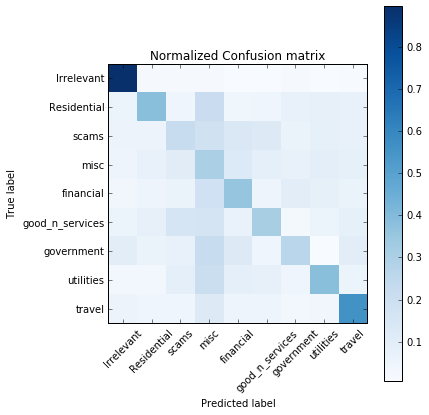


Clasification report of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      5914
          1       0.78      0.69      0.73       269
          2       0.53      0.44      0.48       406
          3       0.45      0.55      0.50       678
          4       0.60      0.67      0.63       456
          5       0.59      0.51      0.55       413
          6       0.87      0.30      0.44        91
          7       0.76      0.64      0.70       272
          8       0.88      0.78      0.82       485

avg / total       0.86      0.86      0.86      8984


Confussion matrix of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_ite

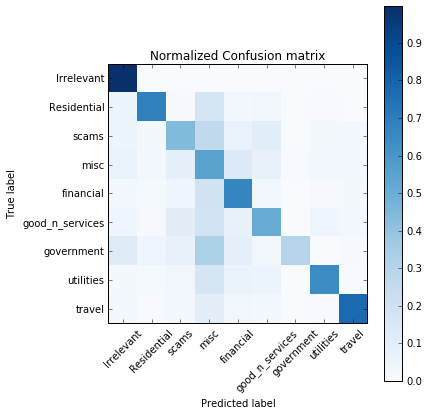


Clasification report of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False):
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      5914
          1       0.87      0.43      0.58       269
          2       0.54      0.21      0.30       406
          3       0.37      0.62      0.46       678
          4       0.60      0.62      0.61       456
          5       0.50      0.31      0.38       413
          6       1.00      0.05      0.10        91
          7       0.75      0.36      0.48       272
          8       0.80      0.71      0.75       485

avg / total       0.83      0.82      0.81      8984


Confussion matrix of RandomF

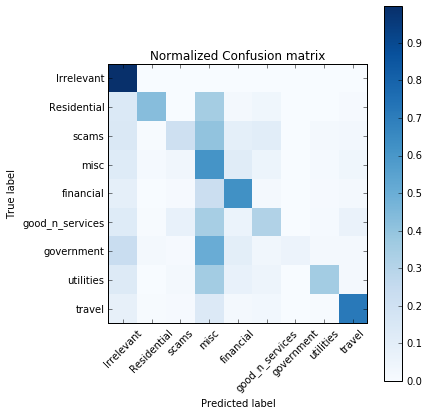

In [46]:
# plot the result of the three models above
model = [gnb_9cate, svc_9cate, clf_9cate]
for i in model:
    pred = i.predict(X_test)
    cm = sklearn.metrics.confusion_matrix(target_test, pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print '\nClasification report of %s:\n' % i, sklearn.metrics.classification_report(target_test, pred)
    print '\nConfussion matrix of %s:\n' % i, sklearn.metrics.confusion_matrix(target_test, pred)
    plt.figure(figsize = (6,6))
    plot_confusion_matrix(cm_normalized, title='Normalized Confusion matrix', label=Index_list)
    plt.show()

In [76]:
# svm recall/precision
pred = svc_9cate.predict(X_test)
cm = sklearn.metrics.confusion_matrix(target_test, pred)
print 'relevent precision', 1-sum(cm[0][1:])/float(sum([sum(cm[i][1:]) for i in range(9)]))
print 'relevent recall', sum([sum(cm[i][1:]) for i in range(1,9)])/float(sum([sum(cm[i]) for i in range(1,9)]))

relevent recall 0.995916978564
relevent precision 0.95342019544


From the result above, we found that svm performed best among these three algorithm.

### Go deep SVM method, tune the parameter

In [132]:
# Support vector machine with penality L2
from sklearn.svm import LinearSVC
start_time = time.time()
sv_l = LinearSVC(loss = 'squared_hinge',penalty = 'l2', dual = False, tol = 1e-3)
sv_l.fit(X_train, target_train)
pred_1 = sv_l.predict(X_test)
end_time = time.time()
print "Accuracy by SVM with L2:", 1.0*sum(target_test==pred_1)/len(pred_1)
print "Training it took %.3f mins" %((end_time-start_time)/60.0)

Accuracy by SVM with L2: 0.857190560997
Training it took 0.037 mins


In [133]:
cm1 = sklearn.metrics.confusion_matrix(target_test, pred_1)
print 'relevent precision', 1-sum(cm1[0][1:])/float(sum([sum(cm1[i][1:]) for i in range(9)]))
print 'relevent recall', sum([sum(cm1[i][1:]) for i in range(1,9)])/float(sum([sum(cm1[i]) for i in range(1,9)]))

relevent precision 0.996273712737
relevent recall 0.957980456026


In [135]:
# Support vector machine with LinearSVC
from sklearn.svm import LinearSVC
start_time = time.time()
sv_2 = LinearSVC()
sv_2.fit(X_train, target_train)
pred_2 = sv_2.predict(X_test)
end_time = time.time()
print("Accuracy by SVM with LinearSVC:", 1.0*sum(target_test==pred_2)/len(pred_2))
print "Training it took %.3f mins" %((end_time-start_time)/60.0)

('Accuracy by SVM with LinearSVC:', 0.8575244879786287)
Training it took 0.018 mins


In [136]:
cm2 = sklearn.metrics.confusion_matrix(target_test, pred_2)
print 'relevent precision', 1-sum(cm2[0][1:])/float(sum([sum(cm2[i][1:]) for i in range(9)]))
print 'relevent recall', sum([sum(cm2[i][1:]) for i in range(1,9)])/float(sum([sum(cm2[i]) for i in range(1,9)]))

relevent precision 0.996273712737
relevent recall 0.957980456026


In [116]:
print '\nClasification report :\n', sklearn.metrics.classification_report(target_test, pred_2)


Clasification report :
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      5914
          1       0.75      0.71      0.73       269
          2       0.48      0.41      0.44       406
          3       0.51      0.47      0.49       678
          4       0.58      0.67      0.62       456
          5       0.54      0.52      0.53       413
          6       0.56      0.31      0.40        91
          7       0.73      0.71      0.72       272
          8       0.81      0.79      0.80       485

avg / total       0.85      0.86      0.85      8984



In [117]:
print '\nConfussion matrix :\n', cm2


Confussion matrix :
[[5903    0    1    4    2    4    0    0    0]
 [  10  190    4   36    8   12    0    3    6]
 [  24    7  168   70   45   61    3   14   14]
 [  40   29   78  319   92   57    8   23   32]
 [  12   12   21   63  304   15    4    9   16]
 [  15    5   51   60   27  216    3   19   17]
 [   7    4    8   20   13    8   28    1    2]
 [   5    2    7   21   20   16    2  194    5]
 [  16    3   12   38   16   12    2    4  382]]


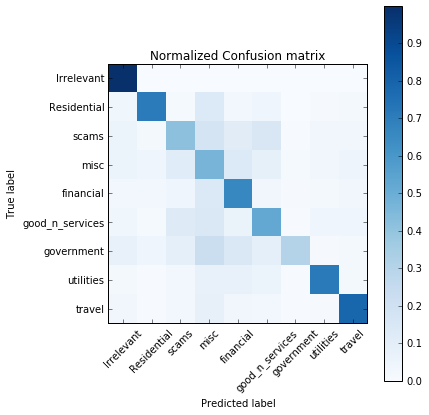

In [118]:
cm_normalized = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (6,6))
plot_confusion_matrix(cm_normalized, title='Normalized Confusion matrix', label=Index_list)
plt.show()

By now, we found the best model is LinearSVC. (without dimension deduction and LDA, will try dimension deduction and LDA later)

### Test model on general tweet

In [119]:
# test on unselected tweet
# Extracting features from the test data using the same vectorizer
X_unselected_tweet = vectorizer.transform(unselected_tweet)
X_unselected_tweet

<20092x7252 sparse matrix of type '<type 'numpy.float64'>'
	with 202206 stored elements in Compressed Sparse Row format>

In [128]:
# Apply SVM model on unselected Tweets
start_time = time.time()
svc_predict = sv_2.predict(X_unselected_tweet.toarray())
end_time = time.time()
(end_time-start_time)/60.0

0.018666903177897137

In [138]:
pred_fraud_tweet_index = []
for a in range(9):
    pred_fraud = [i for i,j in enumerate(svc_predict) if j==a]
    print "The amount of %s tweet: %i" % (Index_list[a], len(pred_fraud))
    pred_fraud_tweet_index.append(pred_fraud)

The amount of Irrelevant tweet: 20062
The amount of Residential tweet: 3
The amount of scams tweet: 4
The amount of misc tweet: 6
The amount of financial tweet: 5
The amount of good_n_services tweet: 3
The amount of government tweet: 1
The amount of utilities tweet: 4
The amount of travel tweet: 4


In [140]:
for i,j in enumerate(pred_fraud_tweet_index):
    if i != 0:
        print "Recognized as %s tweet:" % (Index_list[i])
        print "\n"
        for k in j:
            print unselected_tweet[k]
            print "------"
    print "\n"
    print "___________________________________________________________________________________________________________"



___________________________________________________________________________________________________________
Recognized as Residential tweet:


@LeslieMarshall   white water, accused her husband of being a drug dealer and a murderer, they lived in a tiny house in Arkansas
------
work work work work work work there might be mild repercussions for my attacker if i stay at work work work work work work
------
Welp the whole apartment is clean, vacuumed spots that haven't been vacuumed in weeks I lie prolly since we moved in !
------


___________________________________________________________________________________________________________
Recognized as scams tweet:


@caz_yates these items were removed from @amazonIN India website not the US. The selling of these items is not illegal in the US, apparently
------
@UPSHelp a product was over valued and that's not my fault. Charging $23 in fees for a product worth less then that is not smart
------
@SkypeIndia  BEING IGNORED SINCE 31ST MA

From these 30 tweets that the model recognized as fraud relevent, we read through them and found 8 of them is real fraud and they all contain some company name.

### customize test demo


In [141]:
### customize test demo

test_demo = ["I sent my money to my chase bank, it works really good! I love chase!"]

test_demo_transform = vectorizer.transform(test_demo)
test_result = sv_2.predict(test_demo_transform.toarray())
print "The test tweet is recognized as %s tweet" % Index_list[test_result[0]]

The test tweet is recognized as Irrelevant tweet


In [142]:
test_demo = ["I sent my money to my chase bank, but it results that I lose my money. I wanna talk with chase bank manager tomorrow"]

test_demo_transform = vectorizer.transform(test_demo)
test_result = sv_2.predict(test_demo_transform.toarray())
print "The test tweet is recognized as %s tweet" % Index_list[test_result[0]]

The test tweet is recognized as financial tweet


In [207]:
test_demo = ["work"]
test_demo_transform = vectorizer.transform(test_demo)
test_result = sv_2.predict(test_demo_transform.toarray())
print "The test tweet is recognized as %s tweet" % Index_list[test_result[0]]

The test tweet is recognized as Residential tweet


In [165]:
print pred_fraud_tweet_index[1:]
print Index_list[1:]

[[1550, 12907, 14535], [26, 946, 16427, 16851], [803, 1667, 5242, 5673, 6434, 19603], [2332, 10121, 15397, 16985, 19526], [245, 3009, 16393], [8919], [4599, 5566, 12323, 12444], [508, 3636, 5273, 12756]]
['Residential', 'scams', 'misc', 'financial', 'good_n_services', 'government', 'utilities', 'travel']


In [171]:
test_demo = [unselected_tweet[5242]]
test_demo

['How outrage DLIs Korean Dept federal employees were All were shocked, the Korean department filed a claim demanded a compensation lawsuit.']

In [172]:
test_demo_transform = vectorizer.transform(test_demo)
test_result = sv_2.predict(test_demo_transform.toarray())
print "The test tweet is recognized as %s tweet" % Index_list[test_result[0]]

The test tweet is recognized as misc tweet


## get fraud relevent tweet

In [468]:
# filter method 1: only keep tweets with more than 10 'meaningful' word.
def processing_tweet(path):
    
    start_time = time.time()
    stopwords = nltk.corpus.stopwords.words('english')
    new_tweet = pd.read_csv(path, header=-1)
    print 'raw data amount =', len(new_tweet)
    new_tweet.columns = ['tweet','date','retweet','retweet_count','tweetid','userid', 'follwer','place','geolocation','hashtage']
    tweet_filter = new_tweet.loc[:,["tweet",'date','geolocation']]
    tweet_filter = tweet_filter.drop_duplicates(subset=['tweet'])
    tweet_filter = tweet_filter.dropna(subset=['geolocation'])
    tweet_filter = tweet_filter.dropna(subset=['tweet'])
    tweet_filter.reset_index(drop=True, inplace=True)

    word_len = []
    for tweet in tweet_filter.tweet:
        tempwordlist = []
        for word in re.split('\.|\,|\n| ', tweet):
            if "@" not in word.lower() and word.lower() not in stopwords and len(word)>3 and 'http' not in word and '#' not in word:
                tempwordlist.append(word)
        word_len.append(len(tempwordlist))
    tweet_filter.loc[:,'word_len'] = word_len
    tweet_clean = tweet_filter[tweet_filter.word_len > 10]
    tweet_clean.drop('word_len', axis = 1)

    tweet_clean.reset_index(drop=True, inplace=True)
    print 'cleaned data amount =', len(tweet_clean)
    print "guess relevent amount =", len(tweet_clean)*0.00149
    tweet_input = list(tweet_clean['tweet'])
    alot_tweet = vectorizer.transform(tweet_input)
    svc_predict_alot_tweet = sv_2.predict(alot_tweet.toarray())
    tweet_clean.loc[:,'category'] = svc_predict_alot_tweet
    tweet_result = tweet_clean.loc[tweet_clean['category'] > 0]
    tweet_result.reset_index(drop=True, inplace=True)
    print 'relevent amount =', len(tweet_result)
    end_time = time.time()
    print 'The processing took %.2f mins' % ((end_time-start_time)/60.0)
    return tweet_result

In [469]:
# run on tweets data 1
processed_tweets_1 = processing_tweet("../data/fraud_list_svarmit_location.csv")

raw data amount = 7401520
cleaned data amount = 6382
guess relevent amount = 9.50918
relevent amount = 13
The processing took 2.46 mins


In [475]:
# run on tweets data 2
processed_tweets_2 = processing_tweet("../data/u_v3.csv")

raw data amount = 3004579
cleaned data amount = 7980
guess relevent amount = 11.8902
relevent amount = 13
The processing took 1.49 mins


In [479]:
# run on tweets data 3
processed_tweets_3 = processing_tweet("../data/collect_all_NY_tweets.csv")

raw data amount = 405156
cleaned data amount = 1085
guess relevent amount = 1.61665
relevent amount = 1
The processing took 0.35 mins


In [579]:
# filter method 2: only keep tweets with more than 20 blankspace.

def processing_tweet_update(path):
    
    start_time = time.time()
    stopwords = nltk.corpus.stopwords.words('english')
    new_tweet = pd.read_csv(path, header=-1)
    print 'Tweets amount at begin =', len(new_tweet)
    new_tweet.columns = ['tweet','date','retweet','retweet_count','tweetid','userid', 'follwer','place','geolocation','hashtage']    
    tweet_filter = new_tweet.loc[:,["tweet",'date','geolocation']]
    tweet_filter = tweet_filter.drop_duplicates(subset=['tweet'])
    print 'Tweets amount after dropping retweets =', len(tweet_filter)
    tweet_filter = tweet_filter.dropna(subset=['geolocation'])
    print 'Tweets amount after dropping nan geolocation tweets =', len(tweet_filter)
    tweet_filter = tweet_filter.dropna(subset=['tweet'])
    print 'Tweets amount after dropping empty tweets =', len(tweet_filter)
    tweet_filter.reset_index(drop=True, inplace=True)
    
    tweet_doc = list(tweet_filter['tweet'])
    selected_tweet = [i for i in range(len(tweet_filter)) if type(tweet_doc[i]) == str and len(tweet_doc[i].split()) > 20]
    
    tweet_clean = tweet_filter.iloc[selected_tweet,:]
    tweet_clean.reset_index(drop=True, inplace=True)
    print 'Tweets amount after dropping less than 20 words (model input) =', len(tweet_clean)
    print "Guess relevent tweets amount =", len(tweet_clean)*0.0015
    tweet_input = list(tweet_clean['tweet'])
    alot_tweet = vectorizer.transform(tweet_input)
    svc_predict_alot_tweet = sv_2.predict(alot_tweet.toarray())
    tweet_clean.loc[:,'category'] = svc_predict_alot_tweet
    tweet_result = tweet_clean.loc[tweet_clean['category'] > 0]
    tweet_result.reset_index(drop=True, inplace=True)
    print 'Model predicted relevent tweets amount =', len(tweet_result)
    end_time = time.time()
    print 'The processing took %.2f mins' % ((end_time-start_time)/60.0)
    return tweet_result

In [580]:
processed_tweets_update_1 = processing_tweet_update("../data/fraud_list_svarmit_location.csv")

Tweets amount at begin = 7401520
Tweets amount after dropping retweets = 4939934
Tweets amount after dropping nan geolocation tweets = 211085
Tweets amount after dropping empty tweets = 211085
Tweets amount after dropping less than 20 words (model input) = 7061
Guess relevent tweets amount = 10.5915
Model predicted relevent tweets amount = 18
The processing took 0.80 mins


In [484]:
processed_tweets_update_2 = processing_tweet_update("../data/u_v3.csv")

Tweets amount at begin = 3004579
Tweets amount after dropping retweets = 2696141
Tweets amount after dropping nan geolocation tweets = 275122
Tweets amount after dropping less than 20 words (model input) = 8846
Guess relevent tweets amount = 13.269
Model predicted relevent tweets amount = 22
The processing took 0.43 mins


In [485]:
processed_tweets_update_3 = processing_tweet_update("../data/collect_all_NY_tweets.csv")

Tweets amount at begin = 405156
Tweets amount after dropping retweets = 400409
Tweets amount after dropping nan geolocation tweets = 43885
Tweets amount after dropping less than 20 words (model input) = 1400
Guess relevent tweets amount = 2.1
Model predicted relevent tweets amount = 0
The processing took 0.11 mins


In [497]:
# filter method 3: only keep tweets with more than 10 blankspace.

def processing_tweet_update_10(path):
    
    start_time = time.time()
    stopwords = nltk.corpus.stopwords.words('english')
    new_tweet = pd.read_csv(path, header=-1)
    print 'Tweets amount at begin =', len(new_tweet)
    new_tweet.columns = ['tweet','date','retweet','retweet_count','tweetid','userid', 'follwer','place','geolocation','hashtage']    
    tweet_filter = new_tweet.loc[:,["tweet",'date','geolocation']]
    tweet_filter = tweet_filter.drop_duplicates(subset=['tweet'])
    print 'Tweets amount after dropping retweets =', len(tweet_filter)
    tweet_filter = tweet_filter.dropna(subset=['geolocation'])
    print 'Tweets amount after dropping nan geolocation tweets =', len(tweet_filter)
    tweet_filter = tweet_filter.dropna(subset=['tweet'])
    tweet_filter.reset_index(drop=True, inplace=True)
    
    tweet_doc = list(tweet_filter['tweet'])
    selected_tweet = [i for i in range(len(tweet_filter)) if type(tweet_doc[i]) == str and len(tweet_doc[i].split()) > 10]
    tweet_clean = tweet_filter.iloc[selected_tweet,:]
    tweet_clean.reset_index(drop=True, inplace=True)
    print 'Tweets amount after dropping less than 10 words (model input) =', len(tweet_clean)
    print "Guess relevent tweets amount =", len(tweet_clean)*0.0015
    tweet_input = list(tweet_clean['tweet'])
    alot_tweet = vectorizer.transform(tweet_input)
    svc_predict_alot_tweet = sv_2.predict(alot_tweet.toarray())
    tweet_clean.loc[:,'category'] = svc_predict_alot_tweet
    tweet_result = tweet_clean.loc[tweet_clean['category'] > 0]
    tweet_result.reset_index(drop=True, inplace=True)
    print 'Model predicted relevent tweets amount =', len(tweet_result)
    end_time = time.time()
    print 'The processing took %.2f mins' % ((end_time-start_time)/60.0)
    return tweet_result

In [498]:
processed_tweets_update_10_1 = processing_tweet_update_10("../data/fraud_list_svarmit_location.csv")

Tweets amount at begin = 7401520
Tweets amount after dropping retweets = 4939934
Tweets amount after dropping nan geolocation tweets = 211085
Tweets amount after dropping less than 10 words (model input) = 155898
Guess relevent tweets amount = 233.847
Model predicted relevent tweets amount = 198
The processing took 1.35 mins


In [499]:
processed_tweets_update_10_2 = processing_tweet_update_10("../data/u_v3.csv")

Tweets amount at begin = 3004579
Tweets amount after dropping retweets = 2696141
Tweets amount after dropping nan geolocation tweets = 275122
Tweets amount after dropping less than 10 words (model input) = 204584
Guess relevent tweets amount = 306.876
Model predicted relevent tweets amount = 258
The processing took 1.03 mins


In [500]:
processed_tweets_update_10_3 = processing_tweet_update_10("../data/collect_all_NY_tweets.csv")

Tweets amount at begin = 405156
Tweets amount after dropping retweets = 400409
Tweets amount after dropping nan geolocation tweets = 43885
Tweets amount after dropping less than 10 words (model input) = 31170
Guess relevent tweets amount = 46.755
Model predicted relevent tweets amount = 18
The processing took 0.18 mins


In [506]:
# export the result
tweet_result = pd.concat([processed_tweets_update_10_1,processed_tweets_update_10_2,processed_tweets_update_10_3])
tweet_result = tweet_result.drop_duplicates(subset=['tweet'])
len(tweet_result)

287

In [539]:
tweet_result.columns = ['tweet','date','location','category']

In [538]:
tweet_result.head()

,tweet,date,location,category
0,@MoreOnThisLater @ianmilligan1 is there explic...,Fri Apr 29 00:53:31 +0000 2016,"[-79.4152108, 43.6358113]",2
1,@Newsweek instead of firing shots @realDonaldT...,Fri Apr 29 01:28:10 +0000 2016,"[-73.768984, 40.6954158]",6
2,Look jeffery bought me a grateful dead card......,Fri Apr 29 01:53:26 +0000 2016,"[-76.10361011, 40.51323168]",5
3,Such a long day..poco de gym y a relajarnos en...,Fri Apr 29 03:01:20 +0000 2016,"[-75.62092645, 40.57873674]",5
4,That's why I need all the energy you bring to ...,Fri Apr 29 04:16:44 +0000 2016,"[-73.93111759, 40.85834776]",7


In [554]:
# import the result for geo spatial join with county level 
tweet_result.to_csv('tweet_result_for_geo.csv')
len(tweet_result)

287

In [532]:
# import the result above geo spatial join with county level 
tweet_result_geo = pd.read_csv('../data/counties_tweets.csv')

In [544]:
# tweet_result_geo.columns

In [541]:
tweet_result_geo = tweet_result_geo.loc[:,['tweet','date','GEOID','category']]

In [542]:
tweet_result_geo.head()

,tweet,date,GEOID,category
0,@Newsweek instead of firing shots @realDonaldT...,Fri Apr 29 01:28:10 +0000 2016,36081,6
1,Totally feel awful today. So let's get to pump...,Fri Apr 29 15:18:08 +0000 2016,36081,5
2,Marketing Campaign Manager - RMS Computer Corp...,Fri Apr 29 19:20:14 +0000 2016,36081,2
3,If you have had a joint replacement and taken ...,Wed May 11 15:41:47 +0000 2016,36081,5
4,Time for Zumba session number two! #gymhopping...,Wed May 11 23:07:38 +0000 2016,36081,5


In [552]:
len(tweet_result_geo)

244

In [546]:
list_tweet = list(tweet_result_geo['tweet'])

In [548]:
# search firm name in tweets
def tweetSearch(list_of_tweets):
        
    #Load Firmlist and brake into all firms that are more and less than 3 chareters long
    #If three chareters or less, look for token matches
    #If 4 charteres or more look for compelte string matches
    #Remove manual words
    firmlist = pd.read_pickle('firmlist_update.pkl')
    
    longfirms = firmlist[firmlist.length >= 4]
    shortfirms = firmlist[firmlist.length <= 3]
    longsearch = list(longfirms.search)
    shortsearch = list(shortfirms.search)

    shortfirms_strip = ['ear', 'ace', 'seg', 'les']
    longfirms_strip = ['money', 'chris', 'none', 'tcar', 'same', 'test', "don'tknow", 
                       'peter', 'various', 'unknown', 'charged', 'brooklyn']

    for word in shortfirms_strip:
        if word in shortsearch:
            shortsearch.remove(word)
    for word in longfirms_strip:
        if word in longsearch:
            longsearch.remove(word)
    
    
    
    #get rid of twitter handles, whitespace, retweet=RT, and make all lowercase
    #replace these cleaned tweets with the old tweets
    #drop duplicates
    tweets = pd.DataFrame(list_of_tweets, columns = ['tweet'])
    strippedTweets = []   
    for tweet in tweets.tweet:
            tempTweet = " ".join(filter(lambda x:x[0]!='@', tweet.split()))
            tempTweet = tempTweet.replace(' ', "")
            tempTweet = tempTweet.replace('RT', "")
            tempTweet = tempTweet.lower()
            strippedTweets.append(tempTweet)
    tweets['striped_tweet'] = strippedTweets
    tweets.drop_duplicates(subset = 'striped_tweet', inplace = True)
    tweets.reset_index(drop = True, inplace = True)
    
    #Create tokens out of tweets
    tokenized = []
    for tweet in tweets.tweet:
        tokenized.append(tweet.split())
    tweets['tokens'] = tokenized
    
    #find tweets with firm names within the string
    jackpot_tweet = []
    jackpot_matches = []
    jackpot_cat = []
    for j in range(len(tweets.tokens)):
        if len([i for i in shortsearch if i in tweets.tokens[j]]) > 0:
            tempmatches = [i for i in shortsearch if i in tweets.tokens[j]]
            jackpot_matches.append(set(tempmatches))
            jackpot_tweet.append(tweets.tweet[j])

    for tweet in tweets.striped_tweet:
        if any(x in tweet for x in longsearch):
            tempmatches = {x for x in longsearch if x in tweet}
            jackpot_matches.append(tempmatches)
            jackpot_tweet.append(tweets.loc[tweets['striped_tweet'] == tweet].tweet.iloc[0])
            
    jackpot= pd.DataFrame(jackpot_tweet, columns = ['tweet'])
    jackpot['matches'] = jackpot_matches
    
    now_its_a_list = []
    for i in jackpot.matches:
        if len (list(i)) > 0:
            now_its_a_list.append(list(i))
        else:
            now_its_a_list.append(['unknown'])
    jackpot['matches'] = now_its_a_list
    
    return (list(jackpot.matches))

In [549]:
list_firm = tweetSearch(list_tweet)
list_firm_one = [i[0] for i in list_firm]
tweet_result_geo.loc[:,'firm'] = list_firm_one

In [573]:
tweet_result_geo.loc[:,'firm'] = list_firm_one

In [566]:
remain_company = [i for i in list_firm if i != ['unknown']]
print remain_company
print len(remain_company)

[['24hourfitness'], ['nycha'], ['planetfitness'], ['blinkfitness'], ['libertymutual', 'libertymutualinsurance'], ['citizensbank'], ['citizensbank'], ['citizensbank'], ['aspendental'], ['citizensbank'], ['enterprise'], ['customerservice', 'fedex'], ['newyorksportsclub'], ['chase'], ['chase'], ['customerservice', 'fedex'], ['citizensbank'], ['samsung'], ['kevin'], ['timewarner'], ['newyorksportsclub'], ['planetfitness'], ['blinkfitness'], ['aspendental'], ['libertymutual', 'libertymutualinsurance'], ["macy's"], ['aspendental'], ['allstateinsurance', 'edfinancial', 'allstate'], ['allstateinsurance', 'edfinancial', 'allstate'], ['worldgym'], ['tdbank'], ['timewarner'], ['citizensbank'], ['timewarner'], ['libertymutual', 'libertymutualinsurance'], ['citizensbank'], ['libertymutual', 'libertymutualinsurance'], ['blinkfitness'], ['tdbank'], ['lafitness'], ['tdbank'], ['citizensbank'], ['tdbank'], ['citizensbank'], ['aspendental'], ['retrofitness'], ['libertymutual', 'libertymutualinsurance'],

In [575]:
# export the final result of tweet for build the final table for viz
tweet_result_geo.to_csv('tweets_result.csv')

In [582]:
tweet_result_geo.head()

,tweet,date,GEOID,category,firm
0,@Newsweek instead of firing shots @realDonaldT...,Fri Apr 29 01:28:10 +0000 2016,36081,6,unknown
1,Totally feel awful today. So let's get to pump...,Fri Apr 29 15:18:08 +0000 2016,36081,5,unknown
2,Marketing Campaign Manager - RMS Computer Corp...,Fri Apr 29 19:20:14 +0000 2016,36081,2,unknown
3,If you have had a joint replacement and taken ...,Wed May 11 15:41:47 +0000 2016,36081,5,unknown
4,Time for Zumba session number two! #gymhopping...,Wed May 11 23:07:38 +0000 2016,36081,5,24hourfitness


In [587]:
# take a look on the firm search result
for i in range(244)[:50]:
    if list_firm[i] != ['unknown']:
        print list_firm[i], list_tweet[i]

['24hourfitness'] Time for Zumba session number two! #gymhopping #fitness (@ 24 Hour Fitness in Kew Gardens, NY) https://t.co/xQI4YBOSwm
['nycha'] @RichCimini any chance Jets can pick up Slauson again, cut by the Bears..
['planetfitness'] A grim day at the gym for sure. A grim gym. #blackmetal #watain @ Planet Fitness - Allentown https://t.co/P5Z2nBK4Up
['blinkfitness'] Me at the #gym rn like  #justdoit #fitchick #swole #muscles #squats @ Blink Fitness NoHo https://t.co/QwS5Y5fT3u
['libertymutual', 'libertymutualinsurance'] #Sales #Job alert: Sales Internship Program  New York State | Liberty Mutual Insurance | #NewYork, NY https://t.co/HnENihIZdO #Jobs
['citizensbank'] Citizens Bank #Banking #Job: Mortgage Loan Officer (#NewYork, NY) https://t.co/qwyXPWkMiq #cfgjobs #Jobs #Hiring #CareerArc
['citizensbank'] Citizens Bank #Banking #Job: Mortgage Loan Officer (#NewYork, NY) https://t.co/w3o9NJuyCq #cfgjobs #Jobs #Hiring #CareerArc
['citizensbank'] Citizens Bank #Banking #Job: Mortgage L

# Future Work: Improve the model by adding fraud tweet

In [569]:
fraud_tweet = []

In [570]:
fraud_tweet.append('@FinnGirlJess It could have been fixed here, but my health insurance is Greek, &amp; reimbursement would be an endless bureaucratic nightmare.')